# Importing

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from google.colab.patches import cv2_imshow
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import math
from numpy import array
from google.colab import drive 
import pandas as pd

# Connecting to Google Drive

In [ ]:
# Connect to Google Drive
from google.colab import drive 
drive.mount('/content/gdrive/', force_remount=True)

# Check if path is valid
input_path = '/content/gdrive/My Drive/DATA 245 Group Collaboration/Group Project/Datasets/Dataset Final/'
if os.path.exists(input_path):
  print('Google Drive path to dataset is valid.')

Mounted at /content/gdrive/
Google Drive path to dataset is valid.


# Data Processing & Feature Extraction

In [ ]:
# Dataset is a 2D list of [features] and labels (0=good, 1=bad)
data = []

for label in ['good', 'bad']:
  
  # Get data from the corresponding good/bad subfolders
  #path = os.path.join(input_path, label)
  path = os.path.join(input_path, label + '_augmentation')

  for imgfilename in os.listdir(path):
    imgpath = os.path.join(path, imgfilename)
    star_img = cv2.imread(imgpath, 0)
    
    # Resize from 30x30 to 300x300
    star_img = cv2.resize(star_img, (300,300))

    # Denoise
    star_img_denoised = cv2.fastNlMeansDenoising(star_img, h=11, templateWindowSize=7, searchWindowSize=21)

    # Threshold. Adjust "135" as threshold level
    T, thresh = cv2.threshold(star_img_denoised, 135, 255,	cv2.THRESH_BINARY)
    
    # Obtain contours
    contours, hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]

    # Obtain moments & hu moments
    M = cv2.moments(cnt)
    huMoments = cv2.HuMoments(M)
    
    # Transform hu moments
    for i in range(0,7):
      huMoments[i] = -1 * math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))

    # Store 7 hu moments as features and label into dataset
    data.append([[i[0] for i in huMoments], ['good', 'bad'].index(label), imgfilename])
    

# Data Visualization

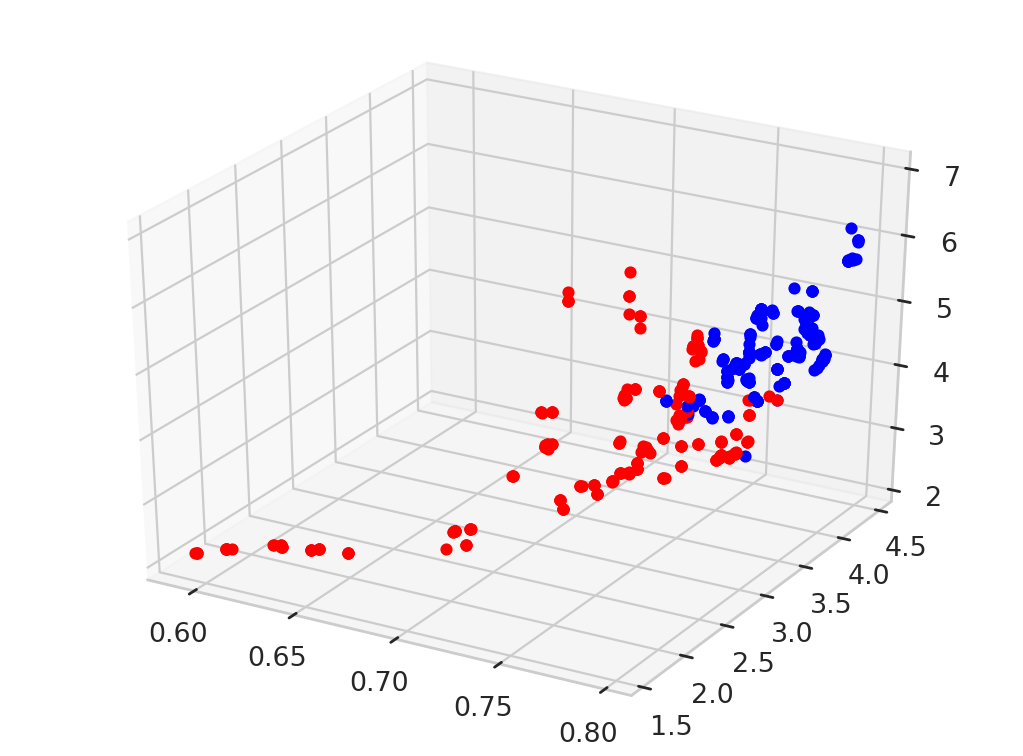

In [ ]:
# 3D plotting using the first 3 hu moments

figure(figsize=(8, 6), dpi=160)

ax = plt.axes(projection='3d')

for point in data:
  if point[1] == 0:
    color = 'blue'
  else:
    color = 'red'
  x = point[0][0]
  y = point[0][1]
  z = point[0][2]
  ax.scatter3D(*zip([x,y,z]), color=color)

In [ ]:
df = pd.DataFrame(data)
df.columns = ['features','label','filename']
df2 = df.features.apply(pd.Series)
df = df2.merge(df, right_index=True,left_index=True)
df = df.drop(['features','filename'],axis=1)

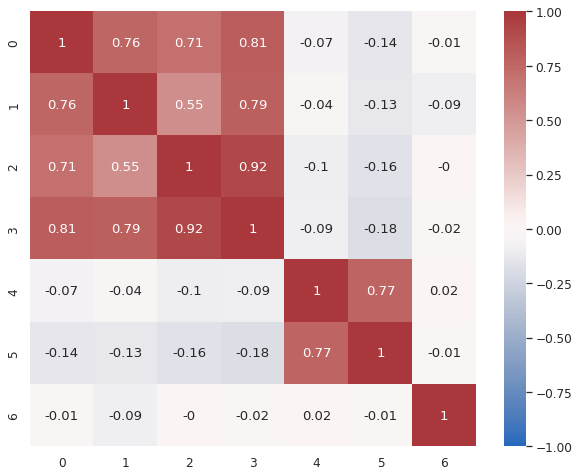

In [ ]:
# check correlation matrix
plt.figure(figsize=(10,8))
corr = df.iloc[:,:-1].corr().round(2)
sns.heatmap(corr, annot=True, vmax=1, vmin=-1,center=0, cmap='vlag')
plt.show()

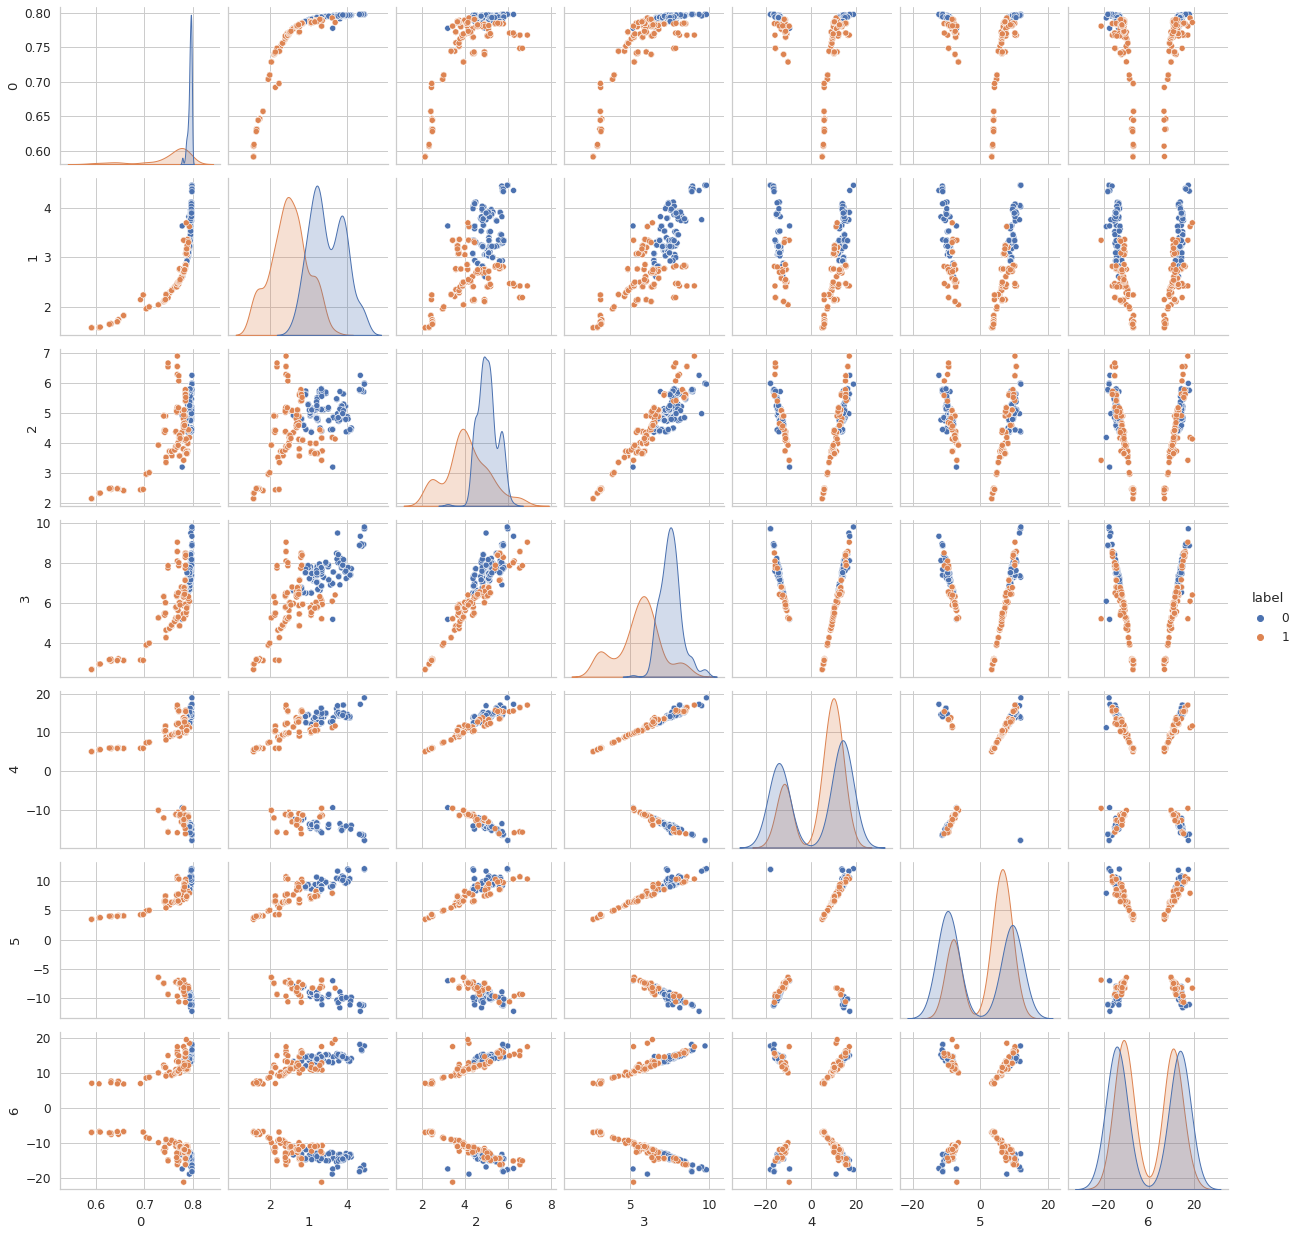

In [ ]:
# feature correlation relationship
sns.set(font_scale=1.1)
sns.set_style('whitegrid')
sns.pairplot(data=df, vars=df.columns[0:-1],hue='label')

# Build models and evaluate

In [ ]:
# Extract features and labels
features = []
labels = []
for feature, label, _ in data:
    features.append(feature)
    labels.append(label)

In [ ]:
# Split data into testing and training
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size=0.2, random_state=5)

## SVM with Polynomial Kernel

In [ ]:
# Create and train SVM polynomial kernel on training data
SVM_poly = SVC(C=1, kernel='poly', gamma='auto')
SVM_poly.fit(xtrain, ytrain)

SVC(C=1, gamma='auto', kernel='poly')

In [ ]:
# Validate SVM polynomial kernel using test data

ypredict_poly = SVM_poly.predict(xtest)
accuracy_poly = SVM_poly.score(xtest, ytest)

print('SVM polynomial kernel accuracy: ', accuracy_poly)

SVM polynomial kernel accuracy:  0.9252336448598131


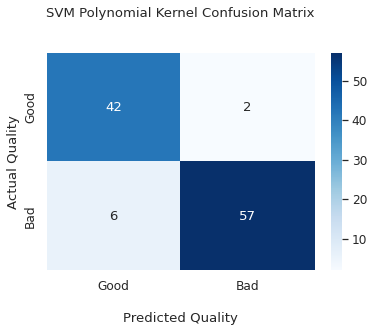

In [ ]:
# Get the confusion matrix
cf_matrix = confusion_matrix(ytest,ypredict_poly)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('SVM Polynomial Kernel Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Quality')
ax.set_ylabel('Actual Quality');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Good', 'Bad'])
ax.yaxis.set_ticklabels(['Good', 'Bad'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print(classification_report(ytest, ypredict_poly))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91        44
           1       0.97      0.90      0.93        63

    accuracy                           0.93       107
   macro avg       0.92      0.93      0.92       107
weighted avg       0.93      0.93      0.93       107



## KNN

In [ ]:
KNN_model = KNeighborsClassifier(4)
KNN_model.fit(xtrain,ytrain)

KNeighborsClassifier(n_neighbors=4)

In [ ]:
# Validate model using test data

ypredict = KNN_model.predict(xtest)
accuracy = KNN_model.score(xtest, ytest)

print('KNN model accuracy: ', accuracy)

KNN model accuracy:  0.897196261682243


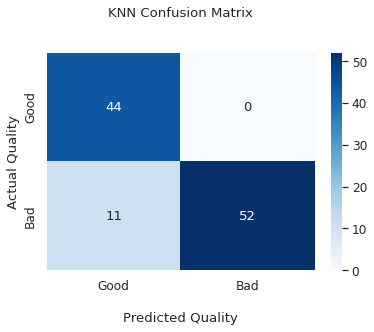

In [ ]:
# Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypredict)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('KNN Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Quality')
ax.set_ylabel('Actual Quality');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Good', 'Bad'])
ax.yaxis.set_ticklabels(['Good', 'Bad'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print(classification_report(ytest, ypredict))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        44
           1       1.00      0.83      0.90        63

    accuracy                           0.90       107
   macro avg       0.90      0.91      0.90       107
weighted avg       0.92      0.90      0.90       107



## Random Forest

In [ ]:
RF_model = RandomForestClassifier()
RF_model.fit(xtrain,ytrain)

RandomForestClassifier()

In [ ]:
# Validate model using test data

ypredict = RF_model.predict(xtest)
accuracy = RF_model.score(xtest, ytest)

print('Random Forest model accuracy: ', accuracy)

Random Forest model accuracy:  0.9813084112149533


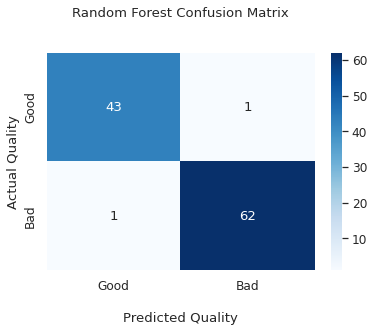

In [ ]:
# Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypredict)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Random Forest Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Quality')
ax.set_ylabel('Actual Quality');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Good', 'Bad'])
ax.yaxis.set_ticklabels(['Good', 'Bad'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print(classification_report(ytest, ypredict))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        44
           1       0.98      0.98      0.98        63

    accuracy                           0.98       107
   macro avg       0.98      0.98      0.98       107
weighted avg       0.98      0.98      0.98       107



### Saving the models into pickle files



In [ ]:
# Save SVC model into pickle file
pkl_filename = os.path.join('/content/gdrive/My Drive/DATA 245 Group Collaboration/Group Project/Saved Models/', 'SVC_Model.pkl')
with open(pkl_filename, 'wb') as file:  
    pickle.dump(SVM_poly, file)

# Save KNN model into pickle file
pkl_filename = os.path.join('/content/gdrive/My Drive/DATA 245 Group Collaboration/Group Project/Saved Models/', 'KNN_Model.pkl')
with open(pkl_filename, 'wb') as file:  
    pickle.dump(KNN_model, file)

# Save KNN model into pickle file
pkl_filename = os.path.join('/content/gdrive/My Drive/DATA 245 Group Collaboration/Group Project/Saved Models/', 'RF_Model.pkl')
with open(pkl_filename, 'wb') as file:  
    pickle.dump(RF_model, file)